<a href="https://colab.research.google.com/github/nezuk00/vis3/blob/main/lab1_california.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Лабораторная работа: Предобработка данных — California Housing

В данной лабораторной работе рассматривается процесс предобработки реального датасета **California Housing Prices**.

Цель работы — подготовить данные для последующего обучения моделей машинного обучения: выполнить загрузку, первичный анализ, обработку пропусков, кодирование категорий, масштабирование числовых признаков и построение пайплайна.

Датасет содержит информацию о жилых районах Калифорнии, включая географические координаты, демографические показатели и медианную стоимость жилья. Целевой признак — `median_house_value` (медианная стоимость дома).


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Импорт библиотек

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# отключение предупреждений
import warnings
warnings.filterwarnings('ignore')


## Загрузка данных

Загрузим данные с помощью функции `fetch_california_housing` из библиотеки `sklearn`. Полученный фрейм данных содержит столбцы с исходными признаками и медианной стоимостью `MedHouseVal`. Для удобства переименуем столбцы и приведём стоимость к долларам (умножим на 100 000).

Также искусственно внесём несколько ошибок и пропусков, чтобы отработать обработку ошибок и заполнение пропусков:

- заменим одно значение в `total_rooms` на строку
- вставим пропуск в `total_bedrooms`
- представим одну стоимость в научной записи как строку

Дополнительно создадим категориальный признак `ocean_proximity` на основе широты: районы севернее 35° будем считать "NEAR BAY", южнее — "INLAND".


In [17]:

!pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np

# Set the path to the file you'd like to load
file_path = "housing.csv"

# Load the latest version of California Housing Prices
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "camnugent/california-housing-prices",
  file_path,
)

# The dataset from kagglehub (camnugent/california-housing-prices) already uses names like
# 'median_income', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', etc.
# The 'rename_dict' from the original notebook referred to column names from the sklearn.datasets version
# (e.g., 'MedInc', 'AveRooms'). Since these are not present in the loaded dataframe, the rename operation
# would not change anything, and subsequent access to 'average_rooms' would fail. For clarity, we remove it.

# Переведем стоимость в доллары (из десятков тысяч). Сначала убедимся, что это число.
df['median_house_value'] = pd.to_numeric(df['median_house_value']) * 100000

# Создадим average_rooms и average_bedrooms на основе существующих total_rooms, total_bedrooms и households.
# Это соответствует духу задачи, где эти признаки часто используются.
df['average_rooms'] = df['total_rooms'] / df['households']
df['average_bedrooms'] = df['total_bedrooms'] / df['households']

# Искусственные ошибки и пропуски
# Заменим одно значение в 'total_rooms' на строку для демонстрации обработки ошибок
df.loc[0, 'total_rooms'] = '1000 rooms'

# Вставим пропуск в 'average_bedrooms' (для демонстрации обработки пропусков)
df.loc[1, 'average_bedrooms'] = np.nan

# Представим одну стоимость в научной записи как строку (для демонстрации обработки ошибок)
df.loc[2, 'median_house_value'] = '3.50e05'

# Дополнительно создадим категориальный признак 'ocean_proximity' на основе широты:
# районы севернее 35° будем считать "NEAR BAY", южнее — "INLAND".
df['ocean_proximity'] = np.where(df['latitude'] >= 35, 'NEAR BAY', 'INLAND')

# Выведем первые строки
print(df.head())


Using Colab cache for faster access to the 'california-housing-prices' dataset.
   longitude  latitude  housing_median_age total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0  1000 rooms           129.0   
1    -122.22     37.86                21.0      7099.0          1106.0   
2    -122.24     37.85                52.0      1467.0           190.0   
3    -122.25     37.85                52.0      1274.0           235.0   
4    -122.25     37.85                52.0      1627.0           280.0   

   population  households  median_income median_house_value ocean_proximity  \
0       322.0       126.0         8.3252      45260000000.0        NEAR BAY   
1      2401.0      1138.0         8.3014      35850000000.0        NEAR BAY   
2       496.0       177.0         7.2574            3.50e05        NEAR BAY   
3       558.0       219.0         5.6431      34130000000.0        NEAR BAY   
4       565.0       259.0         3.8462      34220000000.0        NEAR BAY   



## Первичный анализ данных

Для начала исследуем набор данных: выведем общую информацию, проверим наличие пропусков, посчитаем базовые статистики и построим визуализации для основных признаков.


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  object 
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  object 
 9   ocean_proximity     20640 non-null  object 
 10  average_rooms       20640 non-null  float64
 11  average_bedrooms    20432 non-null  float64
dtypes: float64(9), object(3)
memory usage: 1.9+ MB

Статистические характеристики (числовые колонки):

          longitude      latitude  housing_median_age  total_bedrooms  \
count  

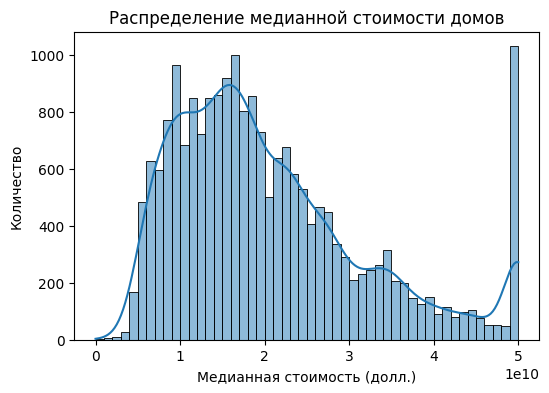

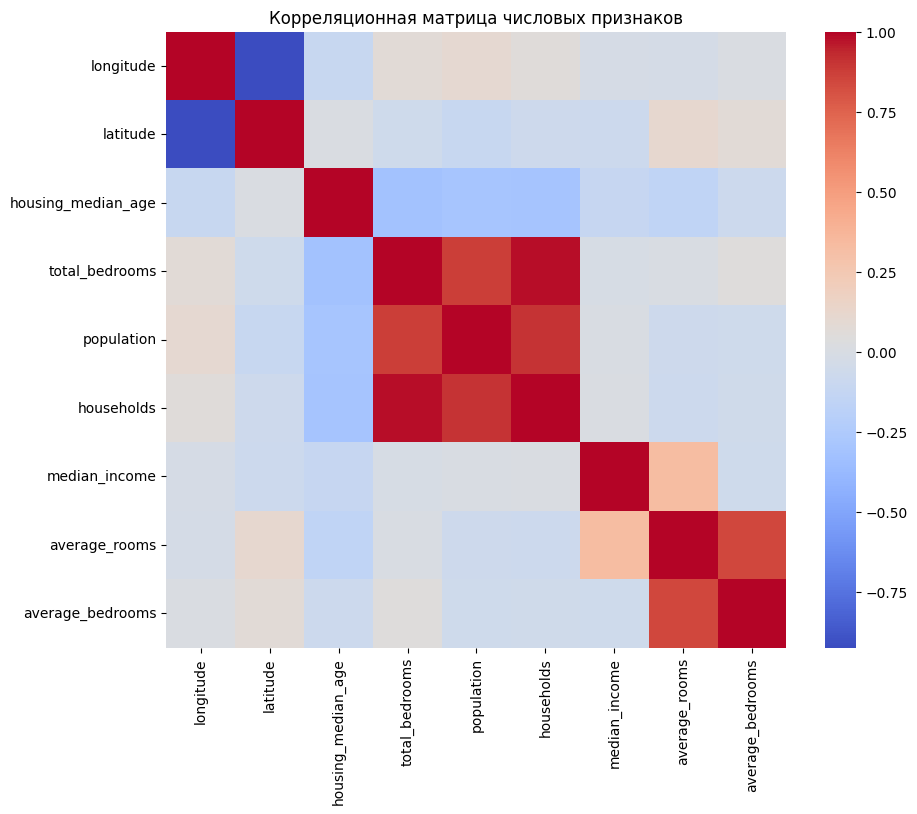

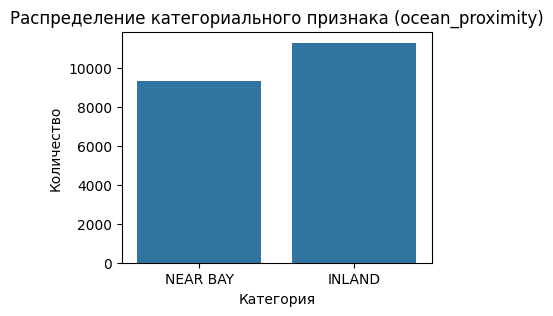

In [18]:

# Информация о данных
print("Информация о данных:")
df_info = df.info()

# Статистические параметры
print("\nСтатистические характеристики (числовые колонки):\n")
print(df.describe(include=[np.number]))

# Число пропусков по каждому столбцу
print("\nКоличество пропусков в каждом столбце:\n")
print(df.isnull().sum())

# Гистограмма целевого признака
plt.figure(figsize=(6,4))
sns.histplot(df['median_house_value'].astype(float), bins=50, kde=True)
plt.title('Распределение медианной стоимости домов')
plt.xlabel('Медианная стоимость (долл.)')
plt.ylabel('Количество')
plt.show()

# Корреляционная матрица (только числовые признаки)
plt.figure(figsize=(10,8))
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

# Распределение категориального признака ocean_proximity
plt.figure(figsize=(4,3))
sns.countplot(x='ocean_proximity', data=df)
plt.title('Распределение категориального признака (ocean_proximity)')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.show()


## Обработка пропусков и ошибок

1. **Приведение типов:** значения в столбцах должны быть числовыми. Заменим строки на числа (например, `'1000 rooms'` → `1000`).
2. **Обнаружение выбросов:** уже на этапе визуализаций видно, что признаки могут иметь существенные выбросы. В этой лабораторной будем только идентифицировать выбросы, оставив их в данных.
3. **Заполнение пропусков:** для числовых колонок будем использовать медиану, для категориальных — наиболее частую категорию.


In [19]:

# Приведение типов
# total_rooms: извлечем число из строки
# если значение не число, заменим его на NaN и потом заполним

def parse_total_rooms(x):
    try:
        return float(str(x).split()[0])
    except:
        return np.nan

df['total_rooms'] = df['total_rooms'].apply(parse_total_rooms)

# median_house_value: преобразуем строку с научной записью к числу

def parse_house_value(x):
    try:
        return float(x)
    except:
        return np.nan

df['median_house_value'] = df['median_house_value'].apply(parse_house_value)

# Заполнение пропусков: медиана для числовых, мода для категориальных
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = ['ocean_proximity']

# Заполним числовые колонки медианой
for col in numeric_cols:
    median = df[col].median()
    df[col].fillna(median, inplace=True)

# Заполним категориальные колонки модой
for col in categorical_cols:
    mode = df[col].mode()[0]
    df[col].fillna(mode, inplace=True)

# Проверим, что пропусков больше нет
print(df.isnull().sum())


longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
average_rooms         0
average_bedrooms      0
dtype: int64


## Кодирование категориальных признаков

Категориальный признак `ocean_proximity` необходимо преобразовать в числовую форму. Используем **One-Hot Encoding** посредством `OneHotEncoder`.


In [6]:

# Определим числовые и категориальные признаки
# numeric_cols obtained from df.select_dtypes(include=[np.number]).columns includes 'median_house_value'
# We need to exclude the target variable from features used for preprocessing
num_features = [col for col in numeric_cols if col != 'median_house_value']
cat_features = ['ocean_proximity']

# Создадим трансформеры для числовых и категориальных признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Соберём ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)


## Масштабирование числовых признаков и итоговый пайплайн

После кодирования категорий проведём стандартизацию числовых признаков с помощью `StandardScaler` и соберём общий пайплайн предобработки.


In [8]:

# Применим пайплайн к данным (без разделения на обучающую и тестовую выборки — это будет в следующей лабораторной)
X = df.drop('median_house_value', axis=1)
y = df['median_house_value']

# Обработаем данные
X_processed = preprocessor.fit_transform(X)

print("Размер обработанной матрицы признаков:", X_processed.shape)

df.to_csv('california_housing_clean_preprocessed.csv', index=False)

print("Файл сохранён под именем 'california_housing_clean_preprocessed.csv'")


Размер обработанной матрицы признаков: (20640, 11)
Файл сохранён под именем 'california_housing_clean_preprocessed.csv'


## Выводы

В ходе лабораторной работы была выполнена комплексная предобработка датасета **California Housing Prices**:

- Загружены данные, переименованы столбцы и создан дополнительный категориальный признак `ocean_proximity`.
- Выявлены и исправлены искусственно внесённые ошибки (строки вместо чисел, пропуски, научная запись).
- Проведён первичный анализ данных: осмотр структуры, подсчёт статистических характеристик, построены гистограммы и корреляционная матрица.
- Выполнена очистка данных: заполнение пропусков медианой/модой, приведение типов.
- Проведено кодирование категориального признака с помощью One-Hot Encoding.
- Выполнена стандартизация числовых признаков и собран итоговый пайплайн предобработки с использованием `ColumnTransformer` и `Pipeline`.

Подготовленный пайплайн можно использовать для дальнейшего обучения моделей машинного обучения и построения нейронных сетей на очищенных и масштабированных данных.
